**This Jupyter Notebook segments objects in images present in folders and extract the diameter of the objects, before plotting them.**
<p>The code has been design to work on such folder architecture: 
    <br>Main_Folder
            <br>&emsp;&emsp;Position_1
            <br>&emsp;&emsp;Position_2
            <br>&emsp;&emsp;...
            <br>&emsp;&emsp;Position_N
    
And when it asks for an image folder, it means a Position_i folder.
<br>
After segmenting the images from the Position_i folder, the code computes the size of each mask and in particular the diameter, and export the value for each images, with the suffix *_data*.
Then, it merges all the data from one image folder into one file with the suffix *data_pos* <br>
Once you are done computing all the image folders, it merges all the data from one image folder into one file with the suffix *data_pos*

    
This notebook requires Cellpose and tqdm (included in the following cellpose install). If not installed, run the following command or find more info at https://github.com/MouseLand/cellpose: </p>

In [ ]:
!pip install cellpose[gui]

<h4>The next section loads the required libraries for the code to work:</h4>

In [1]:
# Import required libraries
import glob
import os
from pathlib import Path
import tkinter
import math

from dataclasses import dataclass

from tqdm.notebook import trange, tqdm

import matplotlib.pyplot as plt
import seaborn as sns
#import ptitprince as pt # if not installed, run: "conda install -c conda-forge ptitprince"

import numpy as np
from tkinter.filedialog import askdirectory, askopenfilename
import pandas as pd
from skimage import io, measure
from cellpose import models, utils, io as iocp

import ipywidgets as widgets

<h3>Then, create a user interface to find the path to a Cellpose model, to determine the pixel size of the image, and to determine the approximate size of the objects to segment. It also asks if you want to use a GPU for the computation.</h3>

<h4> GPU version (CUDA) on Windows or Linux</h4>
If you plan on running many images, you may want to install a GPU version of *torch* (if it isn't already installed).
<br>Before installing the GPU version, remove the CPU version:
<br><code>pip uninstall torch</code>

Follow the instructions <a href="https://pytorch.org/get-started/locally/">here</a> to determine what version to install. The Anaconda install is strongly recommended, and then choose the CUDA version that is supported by your GPU (newer GPUs may need newer CUDA versions > 10.2). For instance this command will install the 11.3 version on Linux and Windows (note the <code>torchvision</code> and <code>torchaudio</code> commands are removed because cellpose doesn't require them):
<br><code>conda install pytorch cudatoolkit=11.3 -c pytorch</code>

In [2]:
# Create a button widget
buttonPathModel = widgets.Button(description="Find path to the model",
                        layout={'height': 'auto', 'width': 'auto'})
# Create a text output widget
outputPathModel = widgets.Text(layout={'height': 'auto', 'width': '75%'})

# Define a function to be called when the button is clicked
def find_path(b):
    # Use the filedialog module to open a file or directory selection dialog
    root = tkinter.Tk()
    root.withdraw()
    root.wm_attributes('-topmost', 1)
    model_path= askopenfilename(title="Path to the model of segmentation",parent=root)
    outputPathModel.value=model_path

# Attach the button-click function to the button widget
buttonPathModel.on_click(find_path)

# Display the button widget in the output area
display(widgets.HBox(children=[buttonPathModel, outputPathModel]))




#%%
# Create a text input widget
pixsize = widgets.FloatText(value=150/208,
                               layout={'height': 'auto', 'width': 'auto'})

# Define a function to be called when the text input is changed
def update_pixsize(change):
    # Update the value of the variable to the current value of the text input
    pixsize.value = change.new
# Attach the text input change function to the text input widget
pixsize.observe(update_pixsize, names="value")

# Display the text input widget in the output area
labelpix = widgets.Label(value="Pixel size (in µm)")
containerpix = widgets.HBox(children=[labelpix, pixsize])
display(containerpix)


# Create a text input widget
diam = widgets.FloatText(value=150,
                         layout={'height': 'auto', 'width': 'auto'})

# Define a function to be called when the text input is changed
def update_diam(change):
    # Update the value of the variable to the current value of the text input
    diam.value = change.new

# Attach the text input change function to the text input widget
diam.observe(update_diam, names="value")

# Display the text input widget in the output area

labeldiam = widgets.Label(value="Approx mean diameter of the EB (in pixels)")
containerdiam = widgets.HBox(children=[labeldiam, diam])
display(containerdiam)


gpuval=widgets.Checkbox(
    value=False,
    description='Use GPU? Check the requirments at https://github.com/MouseLand/cellpose if you think you can.',
    disabled=False,
    indent=False,
    layout={'height': 'auto', 'width': 'auto'}
)
display(gpuval)


Checkbox(value=False, description='Use GPU? Check the requirments at https://github.com/MouseLand/cellpose if …

<h4>Then, create a GUI to select the image folders:</h4>

In [3]:
# Create a button widget
buttonfind_path = widgets.Button(description="Find path to the images", 
                        layout={'height': 'auto', 'width': 'auto'})
# Create a text output widget
folder_path = widgets.Text(layout={'height': 'auto', 'width': '75%'})
# Define a function to be called when the button is clicked
def find_path(b):
    # Use the filedialog module to open a file or directory selection dialog
    root = tkinter.Tk()
    root.withdraw()
    root.wm_attributes('-topmost', 1)
    folder_path.value = askdirectory(title="Path to the folder containing images to be segmented",parent=root)
    
    
# Attach the button-click function to the button widget
buttonfind_path.on_click(find_path)





# Create a text input widget
timeu = widgets.FloatText(value=1,
                                   layout={'height': 'auto', 'width': 'auto'})
# Define a function to be called when the text input is changed
def update_time(change):
    # Update the value of the variable to the current value of the text input
    timeu.value=change.new

    # Attach the text input change function to the text input widget
timeu.observe(update_time, names="value")

# Display the text input widget in the output area
labeltime = widgets.Label(value="Timepoint (in whatever unit you wish)")
containertime = widgets.HBox(children=[labeltime, timeu])
display(containertime)





# Display the button widget in the output area
display(widgets.HBox(children=[buttonfind_path, folder_path]))

<h4>The following section executes the segmentation on the images from the input folder and saves the diameter for each image.</h4>

In [5]:
# Get the list of images in the folder
#image_paths =glob.glob(folder_path + "/*.jpg")
image_paths=iocp.get_image_files(folder_path.value, ['_masks'], imf=None, look_one_level_down=False)

image_paths=list(dict.fromkeys(image_paths)) #remove duplicates using a dictionary fct

# Load the cellpose model
model = models.CellposeModel(gpu=gpuval.value, pretrained_model=outputPathModel.value)

channels=[0,0]
# Segment the image using cellpose
for image_path in tqdm(image_paths, desc='Images', unit='img'):
    img= io.imread(image_path)
    mask, flow, style = model.eval(img,channels=channels,diameter=diam.value)

    iocp.save_masks(img, 
              mask, 
              flow, 
              image_path, 
              channels=channels,
              png=True, # save masks as PNGs and save example image
              tif=False, # save masks as TIFFs
              save_txt=False, # save txt outlines for ImageJ
              save_flows=False, # save flows as TIFFs
              save_outlines=False, # save outlines as TIFFs. Useful to use with ImageJ
              )

    mask2=utils.remove_edge_masks(mask)
    outline=utils.masks_to_outlines(mask2)
    #perimeters=utils.get_mask_perimeters(mask2)
    regions = measure.regionprops(mask2)
    
    diameters=[]
    source_image=[]
    time=[]
    #perimeters2=np.empty((len(regions),1))
    for k in range(len(regions)):
        diameters+=[regions[k].equivalent_diameter_area]
        source_image+=[image_path]
        time+=[timeu.value]
        #perimeters2[k]=regions[k].perimeter

    data=pd.DataFrame({
        'time': time,
        'diameter': diameters,
        'source_image': source_image
        })
    
    data.to_excel((os.path.splitext(image_path)[0] + '_data.xlsx'))
    data.to_pickle((os.path.splitext(image_path)[0] + '_data.pkl'))

#% Merge all the data from the position
data_paths =glob.glob(folder_path.value + "/*data.pkl")

data_pos=pd.DataFrame({
    'time': [],
    'diameter': [],
    'source_image': []
    })
# diameters_pos=pd.DataFrame([])
for data_path in data_paths:
    data = pd.read_pickle(data_path)
    # diameters=np.load(data_path)
    
    pos_name=os.path.basename(folder_path.value).split('_data')[0]
    
    data_pos=pd.concat([data_pos,data],ignore_index=True)
    # diameters_pos=np.append(diameters_all,diameters)

folder_all_path=str(Path(folder_path.value).parent.absolute())
data_pos.to_excel(os.path.join(folder_all_path, pos_name+'_data_pos.xlsx'))
data_pos.to_pickle(os.path.join(folder_all_path, pos_name+'_data_pos.pkl'))

Images:   0%|          | 0/3 [00:00<?, ?img/s]

<h3>Only once all the folders of choice have been segmented, run the next section to merge the data from all the folders into a file ending by "data_all"</h3>

In [6]:
#%%
# Find the parent folder of the folder indicated by the user. This parent folder contains all the data relative to the folder.
folder_all_path=str(Path(folder_path.value).parent.absolute())
data_all_paths =glob.glob(os.path.join(folder_all_path, "*_data_pos.pkl"))


data_all=pd.DataFrame({
    'time': [],
    'diameter': [],
    'source_image': []
    })
for data_pos_path in data_all_paths:
    data_pos = pd.read_pickle(data_pos_path)
    # diameters=np.load(data_path)
    data_all=pd.concat([data_all,data_pos],ignore_index=True)

folder_all_path=str(Path(folder_path.value).parent.absolute())
data_all.to_excel(os.path.join(folder_all_path, 'data_all.xlsx'))
data_all.to_pickle(os.path.join(folder_all_path, 'data_all.pkl'))

<h2>The next section creates a GUI to load the data to plot. If you ran the previous section just before, this section is facultative</h2>

In [9]:
#%%
# Create a button widget
buttonPathData = widgets.Button(description="Find path to the data_all.pkl file",
                        layout={'height': 'auto', 'width': 'auto'})
# Create a text output widget
outputPathData = widgets.Text(layout={'height': 'auto', 'width': '75%'})

if 'folder_all_path' in locals():
    outputPathData.value=os.path.join(folder_all_path, 'data_all.pkl')
# Define a function to be called when the button is clicked
def find_path_data(b):
    # Use the filedialog module to open a file or directory selection dialog
    root = tkinter.Tk()
    root.withdraw()
    root.wm_attributes('-topmost', 1)
    datapkl_path= askopenfilename(title="Path to data_all.pkl file of your project",parent=root)
    outputPathData.value=datapkl_path

# Attach the button-click function to the button widget
buttonPathData.on_click(find_path_data)

# Display the button widget in the output area
display(widgets.HBox(children=[buttonPathData, outputPathData]))



data_all = pd.read_pickle(outputPathData.value)

<h2>The next section to plot the diameters contained in the data_all folder</h2>

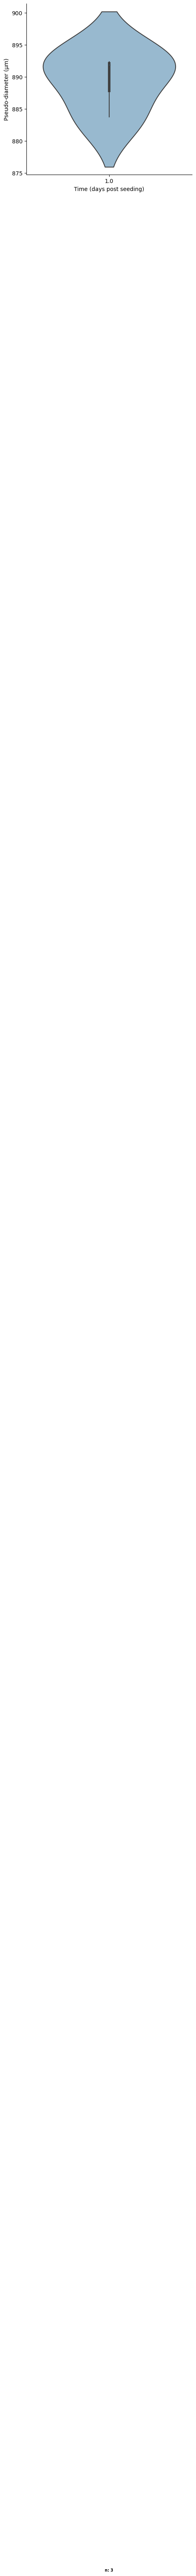

In [10]:
g = sns.catplot(data=data_all, x="time", y="diameter", kind="violin")
g.ax.set(xlabel='Time (days post seeding)', ylabel='Pseudo-diameter (µm)')

nobs = data_all['time'].value_counts().values
nobs = [str(y) for y in nobs.tolist()]
nobs = ["n: " + j for j in nobs]  


pos = range(len(nobs))
for tick in pos:
    g.ax.text(pos[tick], 500, nobs[tick], horizontalalignment='center', size='x-small', color='k', weight='semibold')
    
    
    
#set the alpha for the violin plot (no easier way...)
tmpcol=g.ax.collections[0].get_facecolor()
tmpcol[0,3]=0.5
for violin in g.ax.collections[:]:
    violin.set_facecolor(tmpcol)
    
#sns.swarmplot(data=data_all, x="time", y="diameter", color="k", size=3)
#plt.setp(g.ax.collections, alpha=.3)

plt.savefig(os.path.join(folder_all_path, 'data_all.pdf'))
plt.show()

**If you need to retrain the Cellpose model, first launch Cellpose** and follow the instructions from https://cellpose.readthedocs.io/en/latest/gui.html#training-your-own-cellpose-model

In [ ]:
! python -m cellpose